In [574]:
import networkx as nx
import numpy as np
import copy
from typing import List
from collections import defaultdict


import sys


In [575]:
import sys

sys.path.append("../")
import MMDforGraphs as mg
from importlib import reload  
foo = reload(mg)
nr_nodes_1 = 20
nr_nodes_2 = 20
n = 10
m = 10


average_degree = 2


# bg1 = mg.BinomialGraphs(n, nr_nodes_1, average_degree, l = 'samelabels')
# bg1 = mg.BinomialGraphs(n, nr_nodes_1, average_degree, l = 'degreelabels')
bg1 = mg.BinomialGraphs(n, nr_nodes_1, average_degree, a = 'normattr', l = 'degreelabels', fullyConnected=True )
bg1.Generate()
bg2 = mg.BinomialGraphs(m, nr_nodes_2, average_degree, a = 'normattr', l = 'degreelabels', loc = 5, fullyConnected=True)
bg2.Generate()

Gs = bg1.Gs + bg2.Gs
X = Gs
pos1 = nx.kamada_kawai_layout(X[0])
pos2 = nx.kamada_kawai_layout(X[1])


In [580]:
X[0].nodes[0]['attr']

array([-4.26253935])

{0: '2', 1: '4', 2: '2', 3: '1', 4: '1', 5: '3', 6: '6', 7: '3', 8: '3', 9: '1', 10: '4', 11: '1', 12: '3', 13: '1', 14: '2', 15: '2', 16: '3', 17: '3', 18: '3', 19: '4'}


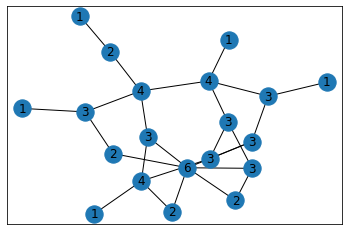

In [558]:

labels1 = nx.get_node_attributes(X[0],'label')
print(labels1)
nx.draw_networkx(X[0], pos = pos1, labels = labels1)


{0: '1', 1: '2', 2: '2', 3: '3', 4: '2', 5: '2', 6: '1', 7: '3', 8: '3', 9: '2', 10: '2', 11: '2', 12: '1', 13: '4', 14: '1', 15: '5', 16: '4', 17: '2', 18: '4', 19: '2'}


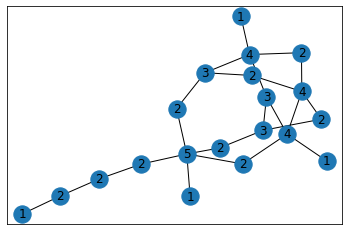

In [559]:
labels2 = nx.get_node_attributes(X[1], 'label')
print(labels2)

nx.draw_networkx(X[1], pos = pos2, labels = labels2)

In [560]:
class WeisfeilerLehman():
    """
    Class that implements the Weisfeiler-Lehman transform
    Credits: Christian Bock and Bastian Rieck
    """
    def __init__(self):
        self._relabel_steps = defaultdict(dict)
        self._label_dict = {}
        self._last_new_label = -1
        self._preprocess_relabel_dict = {}
        
        self._label_dicts = {}

    def _get_next_label(self):
        self._last_new_label += 1
        return self._last_new_label
    
    def _reset_label_generation(self):
        self._last_new_label = -1

    def _relabel_graphs(self, X: list, label_name = 'label'):
        """
        Pre-process so labels go from 0,1,...
        """
        preprocessed_graphs = []
        for i, g in enumerate(X):
            x = g.copy()
                 
            # get label of graph
            labels = nx.get_node_attributes(x,label_name)
            
            new_labels = dict()
            for node, label in labels.items():
                if label in self._preprocess_relabel_dict.keys():
                    new_labels[node] = self._preprocess_relabel_dict[label]
                else:
                    self._preprocess_relabel_dict[label] = self._get_next_label()
                    new_labels[node] = self._preprocess_relabel_dict[label]
            #print(new_labels)
            nx.set_node_attributes(x, {i:l for i, l in new_labels.items()}, label_name)
            self._results[i][0] = (labels, new_labels)
            preprocessed_graphs.append(x)
        self._reset_label_generation()
        return preprocessed_graphs

    def fit_transform(self, X, num_iterations: int=3, label_name = 'label'):
        """
        Returns a dictionary of dicitonaries where first key is wl iteration number, next key is the index of a graph in the sample which gives a tuple 
        where the first element in the tuple is the previous labels (or initial labes) and the next elment in the new labelling according to the wl scheme
        """
        # Pre-process so labels go from 0,1,...
        self._results = defaultdict(dict)

        if type(X) != list:
            X = [X]
        X = self._relabel_graphs(X)

        for it in np.arange(1, num_iterations+1, 1):
            self._reset_label_generation()
            self._label_dict = {}
            for i, g in enumerate(X):

                # Get labels of current interation
                current_labels = nx.get_node_attributes(g,label_name)

                # Get for each vertex the labels of its neighbors
                neighbor_labels = self._get_neighbor_labels(g)

                # Prepend the vertex label to the list of labels of its neighbors
                merged_labels = [[b]+a for a,b in zip(neighbor_labels, current_labels.values())]

                # Generate a label dictionary based on the merged labels
                self._append_label_dict(merged_labels)

                # Relabel the graph
                new_labels = dict()
                new_labels = self._relabel_graph(current_labels, merged_labels)

                self._relabel_steps[i][it] =  { idx: (old_label, merged_labels[idx], list(new_labels.values())[idx]) for idx, old_label in enumerate(current_labels.values()) }
                nx.set_node_attributes(g, {i:l for i, l in zip(current_labels.keys(), new_labels.values())}, label_name)
                self._results[i][it] = (merged_labels, new_labels)
                
            self._label_dicts[it] = copy.deepcopy(self._label_dict)
        
        return self._results



    def _relabel_graph(self, current_labels,  merged_labels: List[list]):
        new_labels = dict()
        for node, merged in zip(current_labels.keys(), merged_labels):
            new_labels[node] = self._label_dict['-'.join(map(str,merged))]
        return new_labels

    def _append_label_dict(self, merged_labels):
        for merged_label in merged_labels:
            dict_key = '-'.join(map(str,merged_label))
            if dict_key not in self._label_dict.keys():
                self._label_dict[ dict_key ] = self._get_next_label()

    def _get_neighbor_labels(self, X:nx.Graph):
        neighbor_indices = [[n_v for n_v in X.neighbors(v)] for v in list(X.nodes)]
        neighbor_labels = []
        for n_indices in neighbor_indices:
            neighbor_labels.append( sorted([X.nodes[v]['label'] for v in n_indices]) )
        return neighbor_labels

[0, 1, 2, 99, 3, 101, 11, 12, 404]

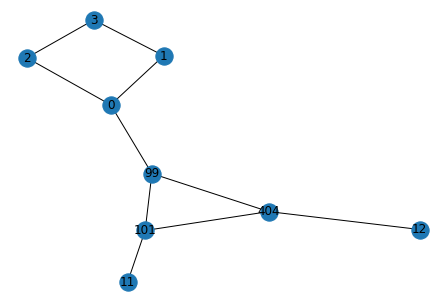

In [561]:
def semi_bfs(G, source, distance):

    node_list = set()
    node_list.add(source)
     
    # Mark all the vertices as not visited

    visited = {i:False for i in  list(G.nodes())}

    # Create a queue for BFS
    current_queue = []

    # Mark the source node as
    # visited and enqueue it
    current_queue.append(source)
    next_queue = []
    visited[source] = True

    if len([n for n in G.neighbors(source)]) == 0:
        return source

    More_things_to_visit = True
    r = 0

    while r < distance and More_things_to_visit:
        # print(visited)
        for i in current_queue:
            neighbours = [n for n in G.neighbors(i)]
            for j in neighbours:
                node_list.add(j)
                if visited[j] == False:
                    visited[j] = True
                    next_queue.append(j)

        r += 1
        # print(next_queue)
        if len(next_queue) == 0:
            # print("More_things_to_visit")
            More_things_to_visit = False

        current_queue = next_queue.copy()
        next_queue = []

    

    return list(node_list)
        


G = nx.Graph()
G.add_nodes_from([0,1,2,3,99, 101, 404, 11, 12])
G.add_edges_from([(0, 1), (0, 2), (1,3), (2,3), (0,99), (99, 101), (101,404), (404,99), (101, 11), (404, 12)])
nx.draw(G, with_labels = True)



semi_bfs(G, 0, 3)
# G = nx.Graph()
# G.add_nodes_from([99])
# semi_bfs(G, 0, 2)



In [562]:
num_graphs = len(X)
convolution_pattern = {graph_nr: {node_nr: list() for node_nr in range(X[graph_nr].number_of_nodes())} for graph_nr in range(num_graphs)}
wwl_pattern_local = {graph_nr: {node_nr: list() for node_nr in range(X[graph_nr].number_of_nodes())} for graph_nr in range(num_graphs)} 
wwl_pattern_local_hash = {graph_nr: {node_nr: list() for node_nr in range(X[graph_nr].number_of_nodes())} for graph_nr in range(num_graphs)} 
distances = [1,2,3]

wl_itr = 4
wl = WeisfeilerLehman()
all_sub_patterns = []
graph_id = []
node_id = []
distance_id = []
for idx, G in enumerate(X):
    for n in G.nodes:
        for r in distances:
            #print(f'{n} {idx} {r}')
            sub_g = G.subgraph(semi_bfs(G, source = n, distance = r)).copy()
            

            #nx.draw_networkx(sub_g, with_labels=True)
            convolution_pattern[idx][n].append( sub_g)
            wwl_pattern_local_hash[idx][n].append( hash( (sub_g.nodes[n]['label']) ) )
            all_sub_patterns.append(sub_g)
            graph_id.append(idx)
            node_id.append(n)
            distance_id.append(r)
    #         break
    #     break
    # break
            

out = wl.fit_transform(all_sub_patterns)

for i in range(len(all_sub_patterns)):
            wwl_pattern_local[graph_id[i]][node_id[i]].append(out[i])


out = wl.fit_transform(X,  4)
vertex_invariant_pattern = {graph_nr: out[graph_nr] for graph_nr in range(num_graphs)} 



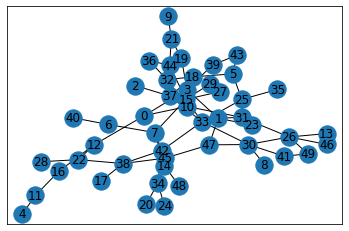

In [547]:
#nx.draw_networkx(X[0], labels = nx.get_node_attributes(X[0], 'label'))
nx.draw_networkx(X[0], with_labels=True)


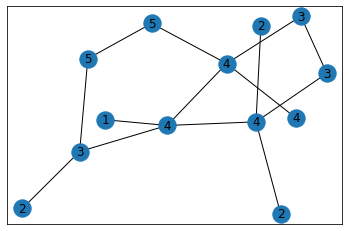

In [548]:
nx.draw_networkx(all_sub_patterns[4], labels = nx.get_node_attributes(all_sub_patterns[4], 'label'))

In [549]:
wwl_pattern_local[0][0][1]

{0: ({0: '3',
   1: '4',
   32: '3',
   3: '4',
   39: '2',
   10: '3',
   12: '3',
   16: '2',
   19: '2',
   22: '3',
   31: '4'},
  {0: 0, 1: 1, 32: 0, 3: 1, 39: 2, 10: 0, 12: 0, 16: 2, 19: 2, 22: 0, 31: 1}),
 1: ([[0, 0, 0, 1],
   [1, 1, 1],
   [0, 0],
   [1, 0, 1, 2, 2],
   [2, 1],
   [0, 0, 0, 1],
   [0, 0, 0, 2],
   [2, 0],
   [2, 1],
   [0, 0],
   [1, 0, 1]],
  {0: 0, 1: 3, 32: 1, 3: 4, 39: 5, 10: 0, 12: 6, 16: 7, 19: 5, 22: 1, 31: 8}),
 2: ([[0, 0, 4, 6],
   [3, 4, 8],
   [1, 0],
   [4, 0, 3, 5, 5],
   [5, 4],
   [0, 0, 1, 8],
   [6, 0, 1, 7],
   [7, 6],
   [5, 4],
   [1, 6],
   [8, 0, 3]],
  {0: 3,
   1: 4,
   32: 1,
   3: 5,
   39: 6,
   10: 7,
   12: 8,
   16: 9,
   19: 6,
   22: 10,
   31: 11}),
 3: ([[3, 5, 7, 8],
   [4, 5, 11],
   [1, 7],
   [5, 3, 4, 6, 6],
   [6, 5],
   [7, 1, 3, 11],
   [8, 3, 9, 10],
   [9, 8],
   [6, 5],
   [10, 8],
   [11, 4, 7]],
  {0: 3,
   1: 4,
   32: 5,
   3: 6,
   39: 7,
   10: 8,
   12: 9,
   16: 10,
   19: 7,
   22: 11,
   31: 12})}

In [550]:
len(out)

9000

In [565]:

graph_db_size = len(X)

K = np.zeros(shape = (graph_db_size, graph_db_size), dtype=float)

for idx1, G1 in enumerate(X):
    for idx2, G2 in enumerate(X):

        if idx1> idx2:
            continue


        weights_matrix = np.zeros((G1.number_of_nodes(), G2.number_of_nodes())) 

        for v_1 in range(G1.number_of_nodes()):
            for v_2 in range(G2.number_of_nodes()):
                
                # compare patters, only compare if r = r
                for r, (pattern_1, pattern_2) in enumerate(zip(convolution_pattern[idx1][v_1],convolution_pattern[idx2][v_2])):

                    # Graph invariant
                    #print(pattern_1.number_of_nodes())
                    #print(pattern_2.number_of_nodes())
                    if pattern_1.number_of_nodes() != pattern_2.number_of_nodes():
                     #   print("continue")
                        continue

                    # No break so now we extract the WL features (label at each wl iteration) and calculate the vertex invariant
                    v_1_score = []
                    for _,v in wwl_pattern_local[idx1][v_1][r].items():
                        #print(v)
                        v_1_score.append(v[1][v_1])
                    
                    v_2_score = []
                    for _,v in wwl_pattern_local[idx2][v_2][r].items():
                        v_2_score.append(v[1][v_2])

                    #print([float(v_1_score[i] == v_2_score[i]) for i in range(len(v_1_score))])
                    #weights_matrix[v_1,v_2]  += np.sum([float(v_1_score[i] == v_2_score[i]) for i in range(len(v_1_score))], dtype=float) / float(len(pattern_1) * len(pattern_2))
                    weights_matrix[v_1,v_2] += 1.0/ float(len(pattern_1) * len(pattern_2))


                weights_matrix[v_1,v_2] *= np.sum([float(vertex_invariant_pattern[idx1][i][1][v_1] == vertex_invariant_pattern[idx2][i][1][v_2])   for i in range(4)], dtype=float)

         

        ones = np.ones((G1.number_of_nodes(),1))
        K[idx1, idx2] = np.sum(weights_matrix) #np.dot(ones.T,weights_matrix).dot(ones) #np.trace(weights_matrix.dot(np.ones(weights_matrix.shape)))




K = K + K.T - np.diag(np.diag(K))




In [552]:
v_1_score

[2, 20, 15684, 43929]

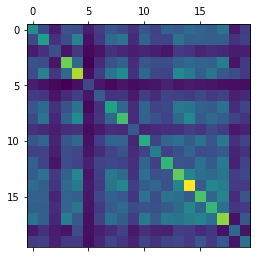

In [566]:
import matplotlib.pyplot as plt
plt.matshow(K)

In [554]:
K

array([[162.03663769,  88.8239146 , 119.77889565, ..., 109.43653398,
        121.36704369, 117.55052891],
       [ 88.8239146 ,  77.95079848,  69.04743254, ...,  76.46182634,
         75.06895938,  78.54035906],
       [119.77889565,  69.04743254, 167.38362464, ...,  95.79903579,
        137.95218101, 108.65016257],
       ...,
       [109.43653398,  76.46182634,  95.79903579, ..., 120.09398341,
        113.14364157, 105.80065348],
       [121.36704369,  75.06895938, 137.95218101, ..., 113.14364157,
        153.23201255, 119.35413907],
       [117.55052891,  78.54035906, 108.65016257, ..., 105.80065348,
        119.35413907, 125.88915777]])

In [555]:
MMD_functions = [mg.MMD_b, mg.MMD_u]

# initialize bootstrap class, we only want this to be initalized once so that numba njit
# only gets compiled once (at first call)
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments=[dict(n = bg1.n, m = bg2.n ), dict(n = bg1.n, m = bg2.n )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 100)
print(kernel_hypothesis.p_values)


{'MMD_b': 0.46, 'MMD_u': 0.46}


In [106]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(K)

True

In [162]:
for k,v in ok.items():
    print(v[1])

{0: 0, 1: 1, 2: 2, 3: 0, 4: 3, 5: 0}
{0: 5, 1: 8, 2: 9, 3: 10, 4: 11, 5: 10}
{0: 30, 1: 31, 2: 32, 3: 33, 4: 34, 5: 33}
{0: 65, 1: 66, 2: 67, 3: 68, 4: 69, 5: 68}
